In [77]:
import pandas as pd
import numpy as np
import os # doesnt have to be installed with pip

import seaborn as sns

In [436]:
df = pd.read_csv('data/Kickstarter_preprocessed.csv')

In [437]:
# delete first column
df.drop(['Unnamed: 0'],axis=1,inplace=True);

# rename some columns
df.rename(columns={'name_category':'category_sub','slug_category':'category','blurb':'description'},inplace=True)

df.category = df.category.apply(lambda x: x.split('/')[0])

In [212]:
#staff_pick -> Vorsicht!
## features to add
# subcategory
# category
# region, state, blub
df['desription'] = df['description'].apply(lambda x: len(str(x).split()))
df = df.eval('usd_goal = static_usd_rate * goal')
df['duration'] = df['deadline'] - df['launched_at']


In [225]:
# create function for format change
# we could also use lambda x: datetime.utcfromtimestamp(x)
from datetime import datetime

def chg_date(x):
    return datetime.utcfromtimestamp(x)

# apply on dataframe

time_col = ['created_at','deadline','state_changed_at','launched_at']
df[time_col] = df[time_col].applymap(chg_date)

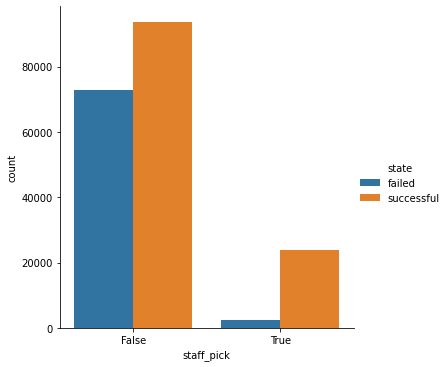

In [373]:
sns.catplot(data=df.query('state in ["successful","failed"]'), x='staff_pick', hue='state', kind='count')

In [415]:
df.category.nunique()

159

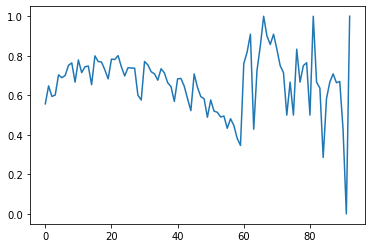

In [168]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(success_per_day)), success_per_day)

In [417]:
durations_list = sorted(list(df.duration_days.unique()))
duration_counts = df.duration_days.value_counts()

countries_list = list(df.country.unique())

categories_list = list(df.category.unique())

In [424]:
def succes_per_feature(df, feature_list, feature_name):
    return [len(df.query('state in ["successful"] & @feature_name==@i'))/len(df.query('state in ["successful","failed"] & @feature_name==@i')) for i in feature_list]


success_per_day = [len(df.query('state in ["successful"] & duration_days==@i'))/len(df.query('state in ["successful","failed"] & duration_days==@i')) for i in durations_list]

success_per_country = [[round(len(df.query('state in ["successful"] & country==@i'))/len(df.query('state in ["successful","failed"] & country==@i')),5), i] for i in countries_list]
success_per_country = sorted(success_per_country, key= lambda x: x[0])

succes_per_category = [[len(df.query('state in ["successful"] & category==@i'))/len(df.query('state in ["successful","failed"] & category==@i')), i] for i in categories_list]

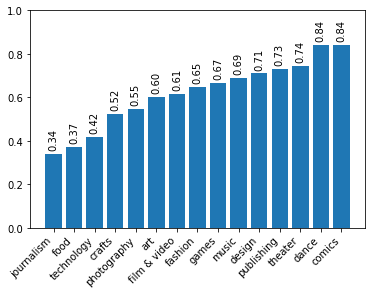

In [429]:
success_per_category = np.array(sorted(success_per_category, key= lambda x: x[0]))

fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
rec = ax.bar(success_per_category[:,1], height=success_per_category[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')

In [443]:
df.query('category=="dance"').category_sub.unique() 

array(['Dance', 'Performances', 'Spaces', 'Workshops', 'Residencies'],
      dtype=object)

In [444]:
df.query('category=="dance" & category_sub=="Spaces"').description

829       We will provide a home to hundreds of dancers ...
959       Help keep this beautiful NYC subsidized rehear...
1017      D.A.B (Dream. And. Believe.) Will be a place w...
1085      We are a 1 year old dance studio in Rochester ...
1137      The dance gathering of your dreams, that also ...
                                ...                        
207734    Impulse teaches the art and expression of danc...
207754    Through creative dance movement and spoken wor...
207817    We are Saving Lives and Changing Lives Through...
207824    We are excited to announce that in July 2015 w...
207881    Trampoline Town is a neighborhood creative spa...
Name: description, Length: 310, dtype: object

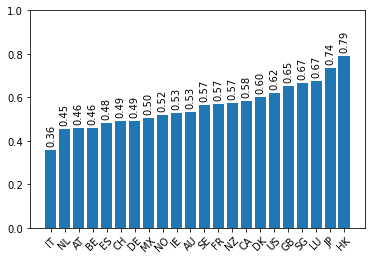

In [358]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.ylim(0,1)
rec = ax.bar(success_per_country[:,1], height=success_per_country[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')

In [384]:
pledged_per_year_month = df.groupby(['start_year','start_month']).sum().usd_pledged.reset_index()
pledged_per_year = df.groupby(['start_year']).sum()

pledged_per_year.loc[2009,'usd_pledged']

for i in range(0,pledged_per_year_month.shape[0]):
    pledged_per_year_month.loc[i,'usd_pledged'] = pledged_per_year_month.loc[i,'usd_pledged'] / pledged_per_year.loc[pledged_per_year_month.loc[i,'start_year'],'usd_pledged']

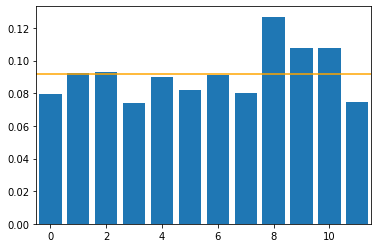

In [477]:
from scipy.interpolate import interp1d
from scipy import interpolate

fig, ax = plt.subplots()
plt.xlim(-0.5,11.5)
#plt.xticks(['January','March'],rotation=45)
rec = ax.bar(x=range(0,12), height=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged)
ax.plot(np.linspace(-0.5,11.5,num=13),np.mean(pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged)*np.ones([13,1]), color='orange')
#tck = interpolate.splrep(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, s=0)
#xnew = np.linspace(0, 11, num=100, endpoint=True)
#ynew = interpolate.splev(xnew, tck, der=0)

#f2 = interp1d(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, kind='cubic')
#plt.plot(np.linspace(0, 10, num=100, endpoint=True), f2(np.linspace(0, 10, num=100, endpoint=True)))

#plt.plot(xnew,ynew)



In [467]:
np.linspace(-0.5,11.5, num=13)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5])

In [280]:
pledged_per_month_perc = pledged_per_year_month/

,start_year,usd_pledged
0,2009,8.153531e+05
1,2010,6.453170e+06
2,2011,2.318343e+07
3,2012,7.743207e+07
4,2013,1.907555e+08
5,2014,2.571229e+08
6,2015,3.591758e+08
7,2016,3.133357e+08
8,2017,4.364007e+08
9,2018,8.615519e+08


In [232]:
######### First feature engineering

# Replace short description of project with length of description
df['description'] = df['description'].apply(lambda x: len(str(x).split()))

# convert all goals into USD
df = df.eval('usd_goal = static_usd_rate * goal')

# create duration of project
df['duration'] = df['deadline'] - df['launched_at']
df['duration_days']=df['duration'].dt.days

# create year and month in which project ist started
df['start_month']= df['launched_at'].dt.month
df['start_year']= df['launched_at'].dt.year

# split text in column category, keep only left part of string --> main category
df.category = df.category.apply(lambda x: x.split('/')[0])

# change to lower case string
df.category_sub = df.category_sub.str.lower()